Deep Learning
=============


The goal of this notebook is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

 The first is the mapping of a high dimensional one-hot style representation of words to a lower dimensional vector. This might involve transforming a 10,000 columned matrix into a 300 columned matrix, for instance. This process is called word embedding.  The second goal is to do this while still maintaining word context and therefore, to some extent, meaning. One approach to achieving these two goals in the Word2Vec methodology is by taking an input word and then attempting to estimate the probability of other words appearing close to that word.  This is called the skip-gram approach.  The alternative method, called Continuous Bag Of Words (CBOW), does the opposite – it takes some context words as input and tries to find the single word that has the highest probability of fitting that context. 
 
What’s a gram?  A gram is a group of n words, where n is the gram window size.  So for the sentence “The cat sat on the mat”, a 3-gram representation of this sentence would be “The cat sat”, “cat sat on”, “sat on the”, “on the mat”.  The “skip” part refers to the number of times an input word is repeated in the data-set with different context words (more on this later).  These grams are fed into the Word2Vec context prediction system. For instance, assume the input word is “cat” – the Word2Vec tries to predict the context (“the”, “sat”) from this supplied input word.  The Word2Vec system will move through all the supplied grams and input words and attempt to learn appropriate mapping vectors (embeddings) which produce high probabilities for the right context given the input words.

# ARCHITECTURE

<img src="Word2Vec-softmax.jpg" style="width:650px;height:300px;">

Consider the diagram below – in this case we’ll assume the sentence “The cat sat on the mat” is part of a much larger text database, with a very large vocabulary – say 10,000 words in length.  We want to reduce this to a 300 length embedding.

With respect to the diagram above, if we take the word “cat” it will be one of the words in the 10,000 word vocabulary.  Therefore we can represent it as a 10,000 length one-hot vector.  We then interface this input vector to a 300 node hidden layer.The weights connecting this layer will be our new word vectors – more on this soon.  The activations of the nodes in this hidden layer are simply linear summations of the weighted inputs (i.e. no non-linear activation, like a sigmoid or tanh, is applied).  These nodes are then fed into a softmax output layer.  During training, we want to change the weights of this neural network so that words surrounding “cat” have a higher probability in the softmax output layer.  So, for instance, if our text data set has a lot of Dr Seuss books, we would want our network to assign large probabilities to words like “the”, “sat” and “on” (given lots of sentences like “the cat sat on the mat”).

By training this network, we would be creating a 10,000 x 300 weight matrix connecting the 10,000 length input with the 300 node hidden layer.  Each row in this matrix corresponds to a word in our 10,000 word vocabulary – so we have effectively reduced 10,000 length one-hot vector representations of our words to 300 length vectors.  The weight matrix essentially becomes a look-up or encoding table of our words.  Not only that, but these weight values contain context information due to the way we’ve trained our network.  Once we’ve trained the network, we abandon the softmax layer and just use the 10,000 x 300 weight matrix as our word embedding lookup table.

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)
print(filename)

Found and verified text8.zip
text8.zip


Read the data into a string.

In [6]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))
print(words[:20])

Data size 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


Build the dictionary and replace rare words with UNK token.

In [10]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  # create a mapping from words to unique integers "dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary) # word, index pairs present
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index) # this is the original text with each word replaced by unique number, and if not found in dictionary then  index is zero
  count[0][1] = unk_count # contains count of each word
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3083, 12, 6, 195, 2, 3137, 46, 59, 156]


Let's display the interal variables to better understand their structure

In [11]:
print(data[:10])
print(count[:10])
print(list(dictionary.items())[:10])
print(list(reverse_dictionary.items())[:10])

[5234, 3083, 12, 6, 195, 2, 3137, 46, 59, 156]
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
[('classification', 2136), ('hindustan', 44612), ('obscuring', 44613), ('discourages', 34664), ('ips', 30965), ('cattle', 4033), ('anthropological', 11887), ('generalized', 7177), ('desserts', 19885), ('conical', 16267)]
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


Function to generate a training batch for the skip-gram model.

In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])
    
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 1
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'a', 'of', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'against', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['a', 'anarchism', 'originated', 'term', 'term', 'of', 'originated', 'as', 'a', 'as', 'of', 'abuse', 'abuse', 'a', 'term', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['as', 'as', 'a', 'a', 'te

Note: the labels is a sliding random value of the word surrounding the words of the batch.

It is not obvious with the output above, but all the data are based on index and not the word directly.

In [13]:
print(batch)
print(labels)

[   6    6    6    6  195  195  195  195    2    2    2    2 3137 3137 3137
 3137]
[[  12]
 [3083]
 [   2]
 [ 195]
 [   6]
 [3137]
 [   2]
 [  12]
 [  46]
 [3137]
 [ 195]
 [   6]
 [  59]
 [  46]
 [ 195]
 [   2]]


Train a skip-gram model.

In [14]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [15]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.224746
Nearest to so: sprite, workforce, malicious, wyche, recover, obtuse, senatorial, rounded,
Nearest to state: sediments, subtrees, jaffna, aligning, overwhelms, iq, renovate, howlin,
Nearest to they: geological, boasted, index, testicles, hn, mitre, backus, dependent,
Nearest to an: borders, uncommonly, disappearance, oasis, clementine, lathes, eleazar, keystroke,
Nearest to years: gohan, precursor, infer, town, division, magnetite, real, drenched,
Nearest to will: watts, skilful, mamet, notional, attrition, tonne, relieve, rooney,
Nearest to but: idi, patented, quarries, adapting, pliny, catalyzes, archetypal, messerschmitt,
Nearest to often: empowerment, deceive, unsuitable, eredivisie, rated, stencil, petitcodiac, kurtz,
Nearest to were: excuse, lasso, assigned, hydroponic, emit, transnational, junction, google,
Nearest to six: shade, obe, recompense, vegan, ghali, defying, cfcs, tj,
Nearest to his: pseudorandom, syrians, accrington, uplift

This is what an embedding looks like.

In [16]:
print(final_embeddings[0])

[-0.05530907 -0.04426871 -0.15154313  0.05694455  0.06174758  0.1130198
  0.21910401  0.13133354 -0.01160298  0.02802351  0.06591336 -0.04075535
 -0.05385546  0.08959921  0.07529896  0.04756219  0.04113686 -0.01666643
 -0.05819019  0.06486415  0.03654681  0.1125804  -0.16273074 -0.02127749
 -0.11832193  0.1592014   0.01472653 -0.07923875  0.14545847  0.15538236
 -0.02282882 -0.10530858 -0.04303479 -0.05441387 -0.01719601 -0.02025172
 -0.06990823 -0.12653768 -0.02567709 -0.04698737  0.03760188 -0.04693555
 -0.17139001  0.01276315 -0.0433127  -0.07832376  0.03322815 -0.06895651
 -0.06195364 -0.11260535  0.00756069 -0.0246796  -0.00275297  0.07089327
 -0.03063949 -0.01584722 -0.234378   -0.12467657 -0.03138579  0.08593676
 -0.15618835 -0.1080884   0.01777431 -0.0270337  -0.00196731  0.00899363
  0.01771306 -0.01177739  0.12383743 -0.07197703  0.08202583 -0.00428062
 -0.05738758  0.3140932  -0.03330153  0.08134785 -0.04843137 -0.04576405
  0.09170681  0.09315263 -0.16852327  0.11549354 -0.

In [20]:
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

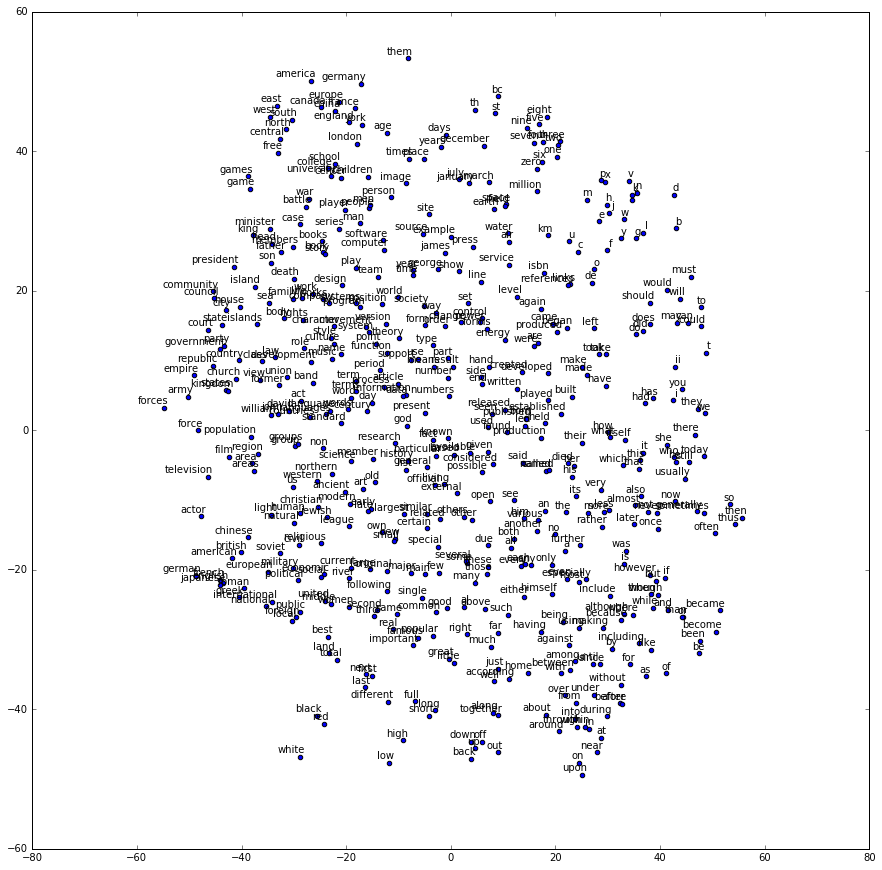

In [21]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

For the continuous bag of words, the train inputs are slightly different from the skip-gram.

In [22]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1)% len(data)
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data: ', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1,2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag window = %d:' % (bag_window))
    print('     batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('     labels:', [reverse_dictionary[li] for li in labels.reshape(4)])






data:  ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag window = 1:
     batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
     labels: ['originated', 'as', 'a', 'term']

with bag window = 2:
     batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
     labels: ['as', 'a', 'term', 'of']


In [23]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
###skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size], dtype = tf.float32))
    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    red_sum = tf.reduce_sum(embeds, 1)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, tf.to_float(train_labels), red_sum, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [24]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, 2)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.130892
Nearest to d: superscript, hernandez, gawain, tala, silvanus, obscene, rake, switchable,
Nearest to or: mottled, fear, pharos, pernambuco, moro, separately, judit, hamilcar,
Nearest to about: intruding, airport, mckenzie, pineapples, dirkjan, punic, moby, beretta,
Nearest to called: rearing, inference, sava, jeopardy, bottlers, simplex, fraught, objectively,
Nearest to more: pieces, boers, godly, felony, deutscher, crewe, madhava, taught,
Nearest to th: bangs, countably, deoxyribose, conjectured, reuptake, banking, puzzle, zola,
Nearest to this: formalization, aravalli, boron, trang, swans, howl, nueva, infamous,
Nearest to they: humanities, deplete, inteligencia, commuting, bootstrap, ayrton, interment, wager,
Nearest to use: cheerleader, indigenous, evading, quine, demonstrations, pretending, usher, causeway,
Nearest to an: weigh, orbiting, cordless, qualcomm, perez, memorized, modern, hindemith,
Nearest to be: bara, situated, hobbes, pris

In [25]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

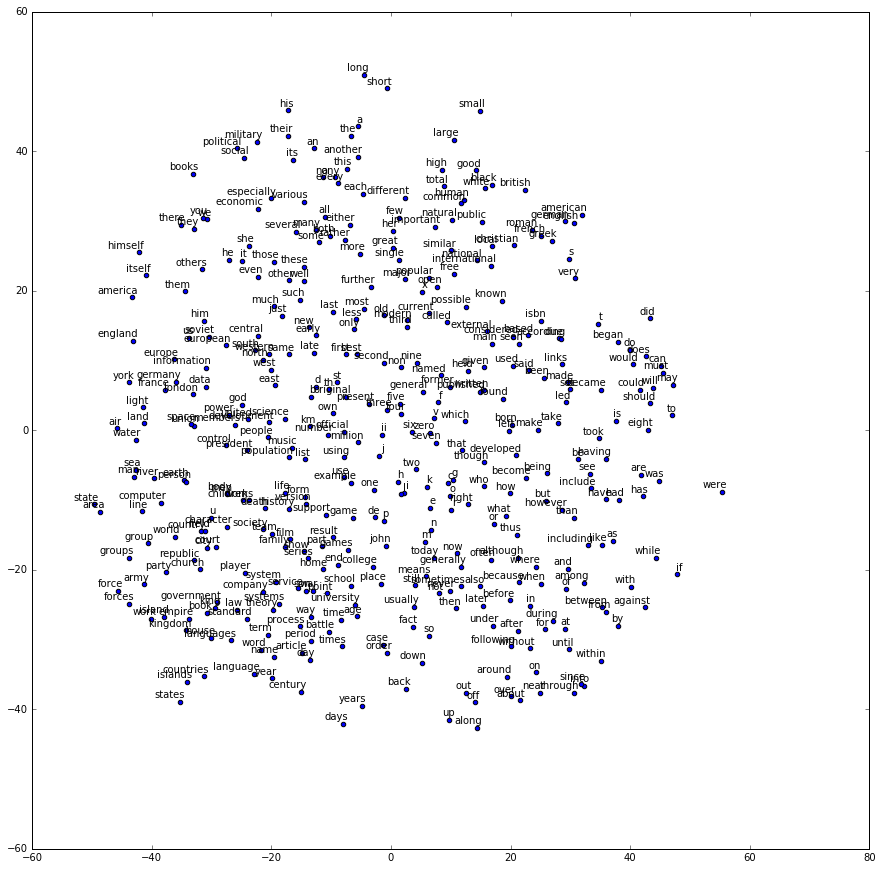

In [26]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)